In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore")


In [2]:
tr_label = pd.read_parquet("transformed_label.parquet", engine="fastparquet")
tr_damage = pd.read_parquet("transformed_damage.parquet", engine="fastparquet")
tr_label = tr_label[['label','transaction_id','n_lines', 'payment_medium',
       'has_feedback', 'feedback_categorical', 'hour',
       'transaction_duration_seconds', 
       'has_voided',  'has_unscanned',
       'has_camera_detected_wrong_product',
       'has_camera_detected_wrong_product_high_certainty',
       'calculated_price_difference', 'has_positive_price_difference',
       'has_snacks']]

# Ermitteln der Datensätze mit sales price = 0, die als Fraud gelabelt wurden, da diese anderweitig ermittelt werden könnten

In [3]:
sales_price_0 = tr_label[(tr_label.has_unscanned == True ) & (tr_label.label == "FRAUD")]
sales_price_0.shape

(11114, 15)

# Ermitteln der Datensätze ohne die oben ermittelten FRAUD-Fälle (die restlcihen FRAUD-Fälle)

In [4]:
# 1. IDs der auszuschließenden Transaktionen ermitteln
exclude_ids = sales_price_0["transaction_id"].unique()

# 2. Alle Transaktionen aus tr_label, die NICHT in exclude_ids sind
tr_label_filtered = tr_label[~tr_label["transaction_id"].isin(exclude_ids)]


#  Ermitteln der Datensätze mit total_amount kleiner als die Summe der sales_prices

In [7]:
rabatte = tr_label[tr_label.has_positive_price_difference == True ]

# Ermitteln der Datensätze ohne die oben ermittelten Rabatt-Datensätze

In [13]:
# 1. IDs der auszuschließenden Transaktionen ermitteln
exclude_ids = rabatte["transaction_id"].unique()

# 2. Alle Transaktionen aus tr_label, die NICHT in exclude_ids sind
tr_label_filtered = tr_label[~tr_label["transaction_id"].isin(exclude_ids)]


In [14]:
tr_label_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136910 entries, 0 to 148023
Data columns (total 15 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   label                                             136910 non-null  object 
 1   transaction_id                                    136910 non-null  object 
 2   n_lines                                           136910 non-null  int64  
 3   payment_medium                                    136910 non-null  object 
 4   has_feedback                                      136910 non-null  bool   
 5   feedback_categorical                              136910 non-null  object 
 6   hour                                              136910 non-null  int8   
 7   transaction_duration_seconds                      136910 non-null  int64  
 8   has_voided                                        136910 non-null  bool   
 9   has_

In [15]:
# "damage" als Merkmal in Datensatz aufnehmen
df = tr_label_filtered.merge(
    tr_damage[["transaction_id", "damage"]],
    on="transaction_id",
    how="left"  # falls manche keinen Schaden haben
)


# Zielvariable vorbereiten

In [16]:


# Zielvariable kodieren (FRAUD = 1, NORMAL = 0)
# Zielvariable
y = df["label"].map({"NORMAL": 0, "FRAUD": 1})

label_encoder = LabelEncoder()
df["label_encoded"] = label_encoder.fit_transform(df["label"])


X = df.drop(columns=["label", "label_encoded", "transaction_id", "damage"])
X = pd.get_dummies(X, columns=["payment_medium"], drop_first=True)
X = pd.get_dummies(X, columns=["feedback_categorical"], drop_first=True)



# Split in Trainings- und Testdaten
X_train, X_test, y_train, y_test, damage_train, damage_test = train_test_split(
    X, y, df["damage"], test_size=0.2, stratify=y, random_state=42
)


In [17]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=8, class_weight="balanced", random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced", solver='liblinear'),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=7, is_unbalance=True, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, scale_pos_weight=30,
                             use_label_encoder=False, eval_metric="logloss", random_state=42)
}


- Modelle mit der besten Kombination aus F1-Score und minimalen Kosten: meist LightGBM oder XGBoost
- Schwellenwertanpassung bringt signifikanten Vorteil gegenüber Standard-Threshold
- Individuelle Bewertungsfunktion hilft, wirtschaftlich optimale Entscheidungen zu treffen

📝 Empfehlung:
Nutze LightGBM oder XGBoost mit Threshold-Tuning im Deployment.


In [35]:
def cost_score(y_true, y_pred, damage):
    cost = 0
    for yt, yp, dmg in zip(y_true, y_pred, damage):
        if yt == 1 and yp == 1:
            cost += 5.00
        elif yt == 1 and yp == 0:
            cost -= dmg
        elif yt == 0 and yp == 1:
            cost -= 30.00
    return cost



🔍 Trainiere Random Forest...
✅ Opt. Threshold: 0.92 | 💰 Bewertung: -1,036.58 €

🔍 Trainiere Logistic Regression...
✅ Opt. Threshold: 0.97 | 💰 Bewertung: -1,453.42 €

🔍 Trainiere Gradient Boosting...
✅ Opt. Threshold: 0.84 | 💰 Bewertung: -929.36 €

🔍 Trainiere LightGBM...
[LightGBM] [Info] Number of positive: 1554, number of negative: 107974
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 656
[LightGBM] [Info] Number of data points in the train set: 109528, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.014188 -> initscore=-4.241058
[LightGBM] [Info] Start training from score -4.241058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

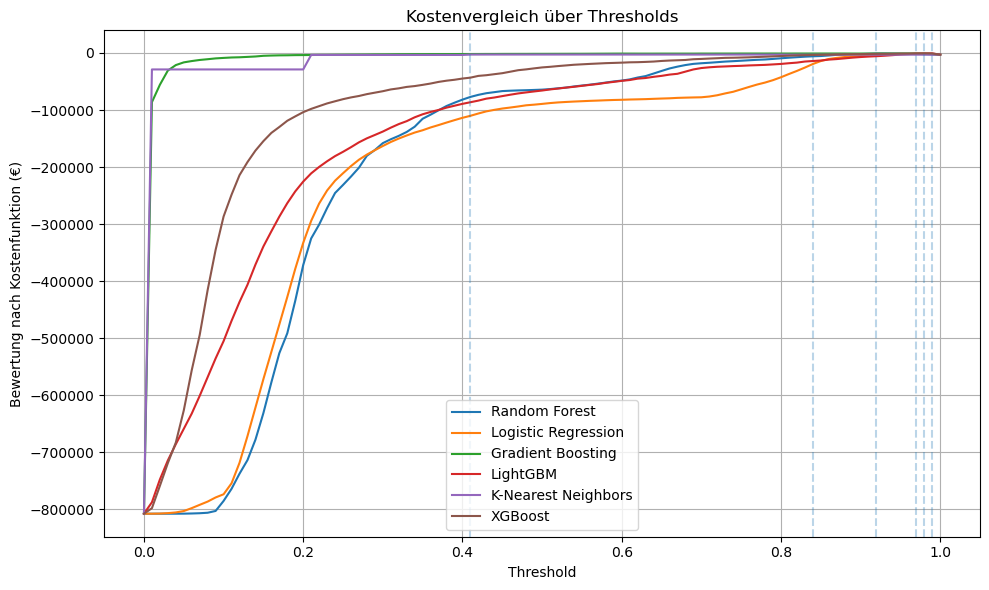

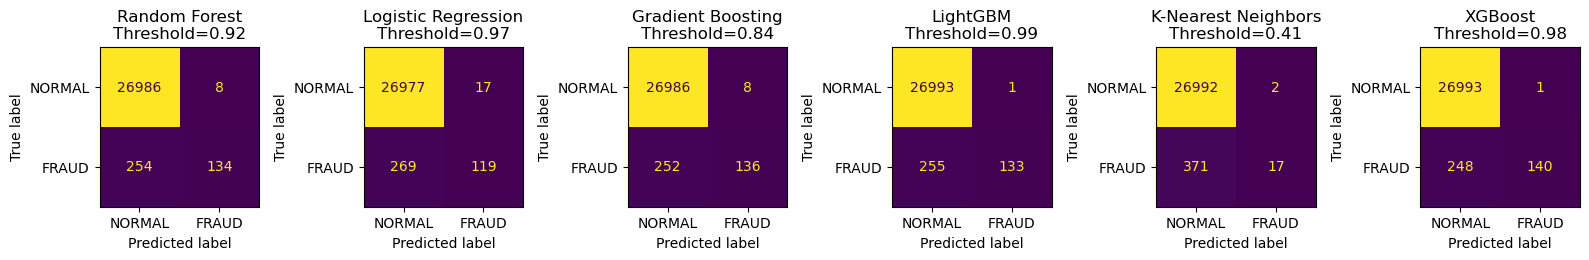

In [36]:



# Ergebnisse sammeln
results = {}

for name, model in models.items():
    print(f"\n🔍 Trainiere {name}...")

    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]

    thresholds = np.arange(0.0, 1.01, 0.01)
    costs = []

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        cost = cost_score(y_test, y_pred, damage_test)
        costs.append(cost)

    optimal_idx = np.argmax(costs)
    optimal_threshold = thresholds[optimal_idx]
    optimal_cost = costs[optimal_idx]

    # Speichern für Vergleich
    results[name] = {
        "model": model,
        "threshold": optimal_threshold,
        "cost": optimal_cost,
        "y_pred": (y_proba >= optimal_threshold).astype(int),
        "confusion": confusion_matrix(y_test, (y_proba >= optimal_threshold).astype(int)),
        "cost_curve": costs
    }

    print(f"✅ Opt. Threshold: {optimal_threshold:.2f} | 💰 Bewertung: {optimal_cost:,.2f} €")

# --------------------------------------
# Plot: Vergleich der Kostenfunktionen
# --------------------------------------
plt.figure(figsize=(10, 6))
for name, res in results.items():
    plt.plot(np.arange(0, 1.01, 0.01), res["cost_curve"], label=name)
    plt.axvline(res["threshold"], linestyle="--", alpha=0.3)

plt.title("Kostenvergleich über Thresholds")
plt.xlabel("Threshold")
plt.ylabel("Bewertung nach Kostenfunktion (€)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------------------------
# Optional: Konfusionsmatrizen anzeigen
# --------------------------------------
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, len(results), figsize=(16, 4))
for i, (name, res) in enumerate(results.items()):
    ConfusionMatrixDisplay(res["confusion"], display_labels=["NORMAL", "FRAUD"]).plot(ax=axes[i], colorbar=False)
    axes[i].set_title(f"{name}\nThreshold={res['threshold']:.2f}")
plt.tight_layout()
plt.show()


In [37]:
# Konfusionsmatrix anzeigen
for name, res in results.items():
    tn, fp, fn, tp = res["confusion"].ravel()
    print(f"🔹 {name} | Threshold: {res['threshold']:.2f} | Cost: {res['cost']:,.2f} €")
    print(f"[[TN: {tn:>5}  FP: {fp:>5}]\n [FN: {fn:>5}  TP: {tp:>5}]]")
    print("-" * 40)

print("**Datensätze ohne Rabatt** ")    
# Klassische Metriken
metrics_df = []
for name, res in results.items():
    y_pred = res["y_pred"]
    metrics_df.append({
        "Modell": name,
        "Threshold": res["threshold"],
        "Kosten (€)": res["cost"],
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred)
    })

# Anzeige
metrics_df = pd.DataFrame(metrics_df).sort_values(by="Kosten (€)", ascending=False)
display(metrics_df.round(3))


🔹 Random Forest | Threshold: 0.92 | Cost: -1,036.58 €
[[TN: 26986  FP:     8]
 [FN:   254  TP:   134]]
----------------------------------------
🔹 Logistic Regression | Threshold: 0.97 | Cost: -1,453.42 €
[[TN: 26977  FP:    17]
 [FN:   269  TP:   119]]
----------------------------------------
🔹 Gradient Boosting | Threshold: 0.84 | Cost: -929.36 €
[[TN: 26986  FP:     8]
 [FN:   252  TP:   136]]
----------------------------------------
🔹 LightGBM | Threshold: 0.99 | Cost: -737.20 €
[[TN: 26993  FP:     1]
 [FN:   255  TP:   133]]
----------------------------------------
🔹 K-Nearest Neighbors | Threshold: 0.41 | Cost: -2,759.44 €
[[TN: 26992  FP:     2]
 [FN:   371  TP:    17]]
----------------------------------------
🔹 XGBoost | Threshold: 0.98 | Cost: -654.35 €
[[TN: 26993  FP:     1]
 [FN:   248  TP:   140]]
----------------------------------------
**Datensätze ohne Rabatt** 


,Modell,Threshold,Kosten (€),Accuracy,Precision,Recall,F1-Score
5,XGBoost,0.98,-654.35,0.991,0.993,0.361,0.529
3,LightGBM,0.99,-737.20,0.991,0.993,0.343,0.510
2,Gradient Boosting,0.84,-929.36,0.991,0.944,0.351,0.511
0,Random Forest,0.92,-1036.58,0.990,0.944,0.345,0.506
1,Logistic Regression,0.97,-1453.42,0.990,0.875,0.307,0.454
4,K-Nearest Neighbors,0.41,-2759.44,0.986,0.895,0.044,0.084


In [31]:
damage_test.sum()

3005.8399999999997